# Applied Data Science Capstone by IBM/Coursera
# Week 2

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find optimal locations for our investments. Specifically, this report will be targeted to stakeholders interested in opening shops in **Niedersachsen (Lower Saxony)**, Germany. Niedersachsen is a Land (German state) in nortwestern Germany. It is the second-largest state by land area, and fourth-largest in population (7.9 million) among the 16 Länder federated as the Federal Republic of Germany.

Since there are lots of informations about big cities we will try to detect **locations that are not already crowded with shops**. We are also particularly interested in **rural areas**. We would also prefer locations **with middle level population**.

We will use our data science powers to generate more information about promissing cities based on this criteria. Advantages of each area will then be clearly expressed so that best possible locations can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number and types of existing shops in the city (any type of shop)
* number of and distance to big cities in the vicinity, if any
* distance of area from city centers

We decided to use locations, centered around city center, to define our area.

Following data sources will be needed to extract/generate the required information:
* Approximate addresses of centers of those areas will be obtained using **geopy.geocoders**
* Number of shops and their type and location in every city will be obtained using **Foursquare API**
* List of cities and their populations will be obtained using **www.citypopulation.de** of Niedersachsen state

### Import necessary Libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

### Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = 'QV1HMDX5C3M2OJAQ55H1Q1DUTJDPJYCFL2LGTHWWNLCQNQGO' # your Foursquare ID
CLIENT_SECRET = 'VWUTB4V23I344MMEGSLQSCI0IDI5VQ0OPHGAKCWYO52ICYKE' # your Foursquare Secret
VERSION = '20200807'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QV1HMDX5C3M2OJAQ55H1Q1DUTJDPJYCFL2LGTHWWNLCQNQGO
CLIENT_SECRET:VWUTB4V23I344MMEGSLQSCI0IDI5VQ0OPHGAKCWYO52ICYKE


In [3]:
from IPython.display import Image

### All Cities in Niedersachsen

Let's find list and populations for centroids of all cities. 

#### This Data is extracted from "https://www.citypopulation.de/"

In [4]:
Niedersachsen_population=pd.read_html("https://www.citypopulation.de/en/germany/niedersachsen/")[1]
NSachsen_Pop=pd.read_csv("Nieder_Cities without Location.csv") #I had to delete some cities manually.
NSachsen_Pop = NSachsen_Pop.rename(columns={'PopulationEstimate2019-12-31': 'Population'})
NSachsen_Pop=NSachsen_Pop.drop(columns=["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1", "Unnamed: 0.1.1.1","PopulationEstimate1995-12-31","PopulationEstimate2001-12-31","PopulationCensus2011-05-09","Unnamed: 7"])
NSachsen_Pop.head()
print(NSachsen_Pop.shape)

(839, 4)


839 cities have been identified in the state of Niedersachsen. City refers to all kinds of settlements. Some of these cities are the size of large cities. However, Niedersachsen is generally a low population density state. This is why Niedersachsen usually has small settlements.

#### Population Histogram : All Cities

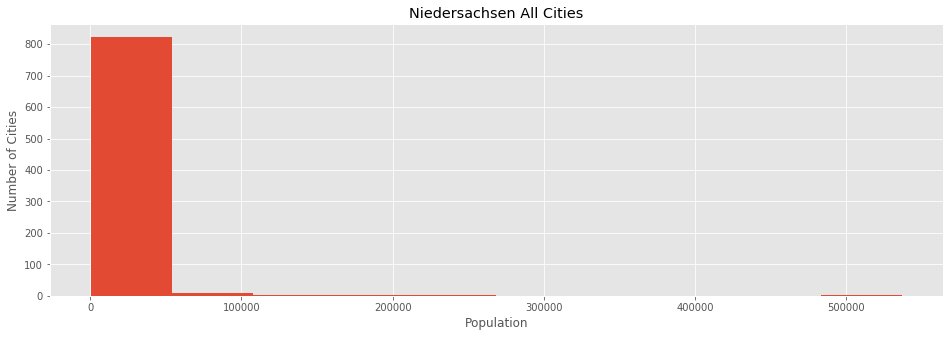

In [5]:
count, bin_edges = np.histogram(NSachsen_Pop['Population'])
NSachsen_Pop['Population'].plot(kind='hist', figsize=(16, 5))
plt.title('Niedersachsen All Cities') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Population') # add x-label
plt.show()

In this histogram, it can be seen that most of the cities are small. In other words, the population of the cities is usually less than 50000.

### Latitude & Longitude Coordinates for All Cities

In [6]:
latitude_niedersachsen=[]
longitude_niedersachsen=[]

for i in NSachsen_Pop['Name']:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(i)
    latitude_niedersachsen.append(location.latitude)
    longitude_niedersachsen.append(location.longitude)

NSachsen_Pop['Lat']=latitude_niedersachsen
NSachsen_Pop['Long']=longitude_niedersachsen     

In [7]:
NSachsen=NSachsen_Pop[['Name','Lat','Long','County','Population']]
print(NSachsen.shape)
NSachsen.head()

(839, 5)


,Name,Lat,Long,County,Population
0,Achim,53.006881,9.042550,Verden,31923.0
1,Adelebsen,51.579484,9.752448,Göttingen,6245.0
2,Adelheidsdorf,52.565616,10.057166,Celle,2641.0
3,Adenbüttel,52.381230,10.451016,Gifhorn,1787.0
4,Adendorf,53.281748,10.439299,Lüneburg,10853.0


Location information for all cities was obtained through geopy.geocoders. Information about shops in all cities will be examined. We will direct our study based on this information.

#### Map (all cities)

In [8]:
def toSimpleMap (Map, latitudes, longitudes, LocationNames):

    

    for lat,lng,city in zip(latitudes, longitudes, LocationNames):
        label = '{}'.format(city)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Map)    

        
#                     ***to use, example***        
#Map = folium.Map(location=[53.007, 9.043], zoom_start=7)
#toSimpleMap (Map, NSachsen_Pop['Lat'], NSachsen_Pop['Long'],NSachsen_Pop['Name'])
#Map     

In [9]:
Map = folium.Map(location=[53.007, 9.043], zoom_start=7)
toSimpleMap (Map, NSachsen['Lat'], NSachsen['Long'],NSachsen['Name'])
Map

All cities are mapped. This includes very small settlements. So we can get an overview of the state of Niedersachsen. 
However, when we examine the map closely, it is seen that the city centers are not located at the center of the residential areas. This is especially true for large populated areas. The information we will obtain through Foursquare is based on coordinates. Information about the shops around these coordinates can be obtained. When these coordinates are at the wrong point of the cities, we cannot get the correct information. Therefore, in our study, not large, but medium-sized cities will be examined. These kinds of cities are already planned to be made in investments.

#### Map (Big Cities)

In [10]:
NSachsen_High=NSachsen[(NSachsen['Population']>50000)]
Map_big = folium.Map(location=[53.007, 9.043], zoom_start=7)
toSimpleMap (Map_big, NSachsen_High['Lat'], NSachsen_High['Long'],NSachsen_High['Name'])
Map_big

In this map we see the major cities in Niedersachsen. The locations of the cities on this map correspond to the population density map. It is a useful map in terms of controlling the location information we have acquired ourselves.

### Middle Cities in Niedersachsen

Let's find list and populations for middle cities. 

In [11]:
NSachsen_Medium=NSachsen[(NSachsen['Population']<20000)&(NSachsen['Population']>5000)]
print(NSachsen_Medium.shape)
NSachsen_Medium.head()

(217, 5)


,Name,Lat,Long,County,Population
1,Adelebsen,51.579484,9.752448,Göttingen,6245.0
4,Adendorf,53.281748,10.439299,Lüneburg,10853.0
5,Aerzen,52.049607,9.263816,Hameln-Pyrmont,10524.0
10,Ahlerstedt,53.406983,9.452321,Stade,5451.0
13,Alfeld (Leine),51.986308,9.824747,Hildesheim,18535.0


217 medium-sized cities of Niedersachsen have been identified. These cities have a population of between 5,000 and 20,000. We already have the location and population information of these cities.

#### Population Histogram : Middle Cities

It is considered that the histogram will be useful to better understand the population information of these cities with medium-sized populations.

In [12]:
count, bin_edges = np.histogram(NSachsen_Medium['Population'])
print(count) # frequency count 
print(bin_edges) # bin ranges, default = 10 bins

[43 35 31 24 22 25  9 11  7 10]
[ 5085.   6560.6  8036.2  9511.8 10987.4 12463.  13938.6 15414.2 16889.8
 18365.4 19841. ]


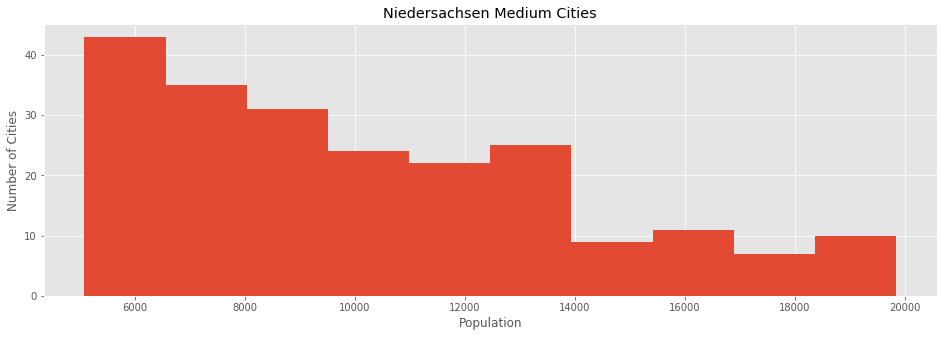

In [13]:
NSachsen_Medium['Population'].plot(kind='hist', figsize=(16, 5))
plt.title('Niedersachsen Medium Cities') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Population') # add x-label
plt.show()

As can be seen, the cities we are studying have usually a population of between 5000 and 15000. For example, about 150 cities have a population between 5000 and 15000. The remaining 70 cities have a population of between 15000 and 20000. However, cities with a population of between 15000 and 20000 still have a significant number. In this study, all of these cities with medium-sized population will be examined. Thus, we have used our Niedersachsen demographic information in our study.

#### Map (Middle Cities)

Medium sized cities have been mapped.

In [14]:
Map = folium.Map(location=[53.007, 9.043], zoom_start=7)
toSimpleMap (Map, NSachsen_Medium['Lat'], NSachsen_Medium['Long'],NSachsen_Medium['Name'])
Map

It is clear from this map that we can get an idea of the whole state of Niedersachsen by examining the medium-sized cities. As it seems, almost the entire state of Niedersachsen is covered. However, it is striking that the surroundings of large cities appear empty on the map. Because there are densely populated settlements around big cities.

----
----
----

## Let's create a function to find the Venues (shops etc.)

In [15]:
def getNearbyVenues(names, latitudes, longitudes, populations, radius=3000):
    LIMIT=100
    venues_list=[]
    for name, lat, lng, pop in zip(names, latitudes, longitudes, populations):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            pop,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude',
                  'City Population',           
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## The Venues will be extracted
#### Now write the code to run the above function on each Middle-City and create a new dataframe called *NSachsen_Medium_venues*.

In this study, shops, namely venues, in cities with medium-sized population are examined. It is desired to reach the information about what kind of businesses are there in these cities. We will access this information via Foursquare.

In [16]:
NSachsen_Medium_venues = getNearbyVenues(names=NSachsen_Medium['Name'],
                                   latitudes=NSachsen_Medium['Lat'],
                                   longitudes=NSachsen_Medium['Long'],
                                   populations=NSachsen_Medium['Population']             
                                  )

Adelebsen
Adendorf
Aerzen
Ahlerstedt
Alfeld (Leine)
Algermissen
Ankum
Apen
Auetal
Bad Bentheim
Bad Bevensen
Bad Essen
Bad Fallingbostel
Bad Gandersheim
Bad Grund (Harz)
Bad Iburg
Bad Laer
Bad Lauterberg im Harz
Bad Münder am Deister
Bad Nenndorf
Bad Pyrmont
Bad Rothenfelde
Bad Sachsa
Bad Salzdetfurth
Bakum
Bardowick
Barnstorf
Barßel
Bassum
Belm
Bersenbrück
Beverstedt
Bienenbüttel
Bispingen
Bissendorf
Bleckede
Bockenem
Bodenwerder
Bohmte
Bomlitz
Bösel
Bovenden
Brake (Unterweser)
Braunlage
Bremervörde
Bruchhausen-Vilsen
Bückeburg
Bunde
Butjadingen
Calberlah
Cappeln
Clausthal-Zellerfeld
Coppenbrügge
Cremlingen
Dannenberg
Delligsen
Diekholzen
Diepholz
Dinklage
Dissen am Teutoburger Wald
Dörpen
Dörverden
Dötlingen
Drochtersen
Ebstorf
Edemissen
Elsfleth
Elze
Emlichheim
Emmerthal
Emsbüren
Emstek
Eschede
Esens
Essen/Oldenburg
Esterwegen
Faßberg
Fredenbeck
Freren
Fürstenau
Geeste
Glandorf
Gleichen
Gnarrenburg
Goldenstedt
Grasberg
Großefehn
Großenkneten
Großheide
Hage
Hagen am Teutoburger Wald
H

#### Let's check the size of the resulting dataframe

In [17]:
print(NSachsen_Medium_venues.shape)
NSachsen_Medium_venues.head()

(1391, 8)


,City,City Latitude,City Longitude,City Population,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adelebsen,51.579484,9.752448,6245.0,REWE,51.578532,9.759187,Liquor Store
1,Adelebsen,51.579484,9.752448,6245.0,Vibro Analytics i. G. haftungsbeschränkt,51.578897,9.753018,Construction & Landscaping
2,Adelebsen,51.579484,9.752448,6245.0,Bahnhof Adelebsen,51.577796,9.759529,Train Station
3,Adelebsen,51.579484,9.752448,6245.0,Bahnhof Lödingsen,51.589336,9.790792,Train Station
4,Adendorf,53.281748,10.439299,10853.0,Alcedo Spa,53.289960,10.457622,Gym


Thus, we learned about 1398 Venue. We now know their locations, the cities they are in, the locations of these cities and the populations of these cities. This information constitutes the basis of our work. In this study, a conclusion will be made based on the information.

### !!! We have *1398* Venues in all middle cities in Niedersachsen (based on our criterias: in 3 km of the points )

----

### Let's see Venues on Map

These venues have been transferred to the map. It seems that all of them are distributed throughout Niedersachsen.These are investments that are open to the daily use of the people in medium-sized settlements in the German state of Niedersachsen.

In [18]:
venues = folium.Map(location=[52.0, 9.0], zoom_start=7)

for lat,lng,city in zip(NSachsen_Medium_venues['Venue Latitude'], NSachsen_Medium_venues['Venue Longitude'],NSachsen_Medium_venues['Venue']):
    folium.CircleMarker(
    [lat,lng],
    radius=0.3,
    color='red',
    parse_html=False).add_to(venues)
venues

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting rural areas of Niedersachsen that have low shop density, particularly those with medium number of population. We will limit our analysis to area ~3km around city center.

In first step we have collected the required **data: location and type (category) of every shops within 3km from each city center**(according to Foursquare categorisation). We have also **Population Data for each City**.

Second step in our analysis will be calculation and exploration of '**shop density**' across different areas of Niedersachsen - we will use **Scatter Plots and Histograms** to identify a few promising areas close to center with high number of shops in general.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **diffirent kinds of Venue Category**, and we want locations **with high population**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify zones / cities / addresses and search for optimal venue locations by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of Venues in every City**:

#### The Count of All Venues for each Middle-City in Niedersachsen

In [19]:
NSachsen_Medium_venues_count = NSachsen_Medium_venues[['City']].groupby(['City'])['City'] \
                                                         .count() \
                                                         .reset_index(name='count') \
                                                         .sort_values(['count'], ascending=False) \
                                                         
print(NSachsen_Medium_venues_count.shape)
NSachsen_Medium_venues_count.head(25)

(217, 2)


,City,count
100,Hemmingen,45
1,Adendorf,27
33,Bispingen,23
42,Braunlage,21
125,Lemwerder,20
19,Bad Nenndorf,18
9,Bad Bentheim,16
48,Bückeburg,16
4,Alfeld (Leine),15
26,Barnstorf,15


We now know the Venue numbers for each city. For example, there are 42 Venue in Hemmingen. Hemmingen is a highly populated city. Therefore, the number of Venue is also very high. I wonder if this applies to all cities? So, does a city's population increase in proportion to its Venue number? The best way to find the answer to this question is to compare the population of each city with the number of Venue. It is convenient to do this comparison with line plot. For this, of course, applying normalization to the population column will give a better result. Let's see the relationship between Population and Count.

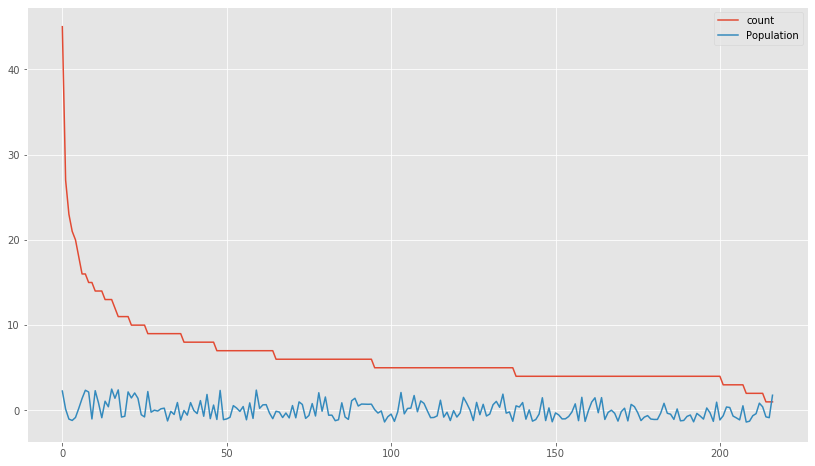

In [20]:
NSachsen_Medium_venues_count1=NSachsen_Medium_venues_count.reset_index()
NSachsen_Medium_venues_count2=NSachsen_Medium_venues_count1.join(NSachsen_Medium.set_index('Name'), on='City')

from scipy.stats import zscore
NSachsen_Medium_venues_count2['Population']=NSachsen_Medium_venues_count2[['Population']].apply(zscore)

NSachsen_Medium_venues_count2[['count','Population']].plot(kind='line', figsize=(14, 8))

It appears that there is no connection in the Line Plot. In other words, with the decrease in the number of Venue, the population number does not decrease regularly. Based on the information we have, we cannot establish a relationship between the population and the Venue Count. An important reason for this is that, in my opinion, the information received from Foursquare is not at a perfect level. Normally, as the population increases, the number of Venue there should also increase. Another reason may be the accuracy of our locations, that is, our latitude and longitude information. The latitude and longitude information specified in the information in the hand does not always indicate the center of the city in terms of population density. Latitude Longitude information sometimes shows the geographical center of the city. Therefore, this point can sometimes be a location in the middle of agricultural lands. Therefore, information received from Foursquare may not be secure enough. However, we will ignore this situation in this study. Because our primary goal is to follow a certain methodology. We will see the result together.

### Histogram :Counf of Venues

We will use the histogram plot to analyze the Venue numbers more closely.

In [21]:
count, bin_edges = np.histogram(NSachsen_Medium_venues_count['count'],4)

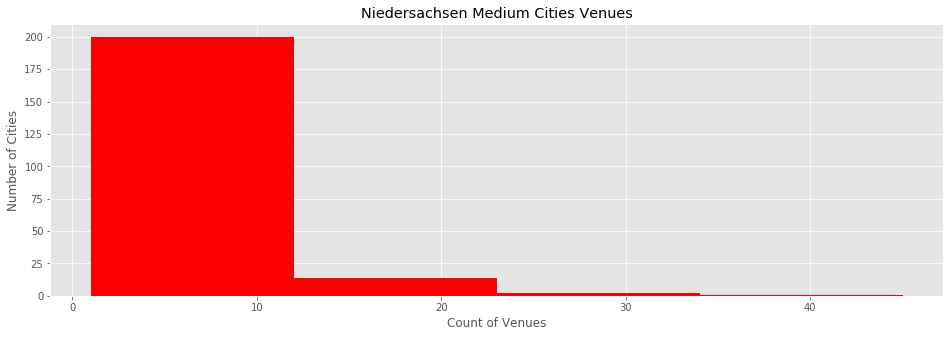

In [22]:
NSachsen_Medium_venues_count['count'].plot(kind='hist', figsize=(16, 5), color=['red'], bins=4)
plt.title('Niedersachsen Medium Cities Venues')  
plt.ylabel('Number of Cities')
plt.xlabel('Count of Venues') 
plt.show()

As seen in the histogram plot, there are less than 10 venues in most cities. The biggest reason for this is that the cities we studied are generally settlements with small population density. Our aim is to invest in these regions. Therefore, the obtained Venue number information does not logically completely conflict with the population information. However, it should be kept in mind that there is no linear regression between the population and Venue numbers.

### Let's have a new Dataframe that shows the Venue Counts and Population together

May be we can cluster Cities based on Population or Venue Counts. We know that there is no linear relationship between population and Venue Count. This does not mean that there is no link between them. So we will try to make a grouping based on these two pieces of information. Our aim is to see if a meaningful photo will come out.

In [23]:
NSachsen_Medium_venues_count_Pop=NSachsen_Medium_venues_count.join(NSachsen_Medium.set_index('Name'), on='City')

In [24]:
print(NSachsen_Medium_venues_count_Pop.shape) # add population
NSachsen_Medium_venues_count_Pop.head()

(217, 6)


,City,count,Lat,Long,County,Population
100,Hemmingen,45,52.316700,9.750000,Region Hannover,18974.0
1,Adendorf,27,53.281748,10.439299,Lüneburg,10853.0
33,Bispingen,23,53.082303,9.996472,Heidekreis,6410.0
42,Braunlage,21,51.726439,10.610052,Goslar,5795.0
125,Lemwerder,20,53.161712,8.608151,Wesermarsch,7122.0


### And now, let's have 4 type of City "Based on Venue Count and Populations"  

In [25]:
clustering_totalVenuePops=NSachsen_Medium_venues_count_Pop.drop(columns=["City","Lat","Long","County"])
kclusters_totalVenuePops = 4
kmeans_totalVenuePops = KMeans(n_clusters=kclusters_totalVenuePops, random_state=0).fit(clustering_totalVenuePops)
NSachsen_Medium_venues_count_Pop.insert(0, 'Cluster Labels_TotalVenueCount', kmeans_totalVenueCounts.labels_)

NameError: name 'kmeans_totalVenueCounts' is not defined

In [ ]:
NSachsen_Medium_venues_count_Pop.head()

In [ ]:
count, bin_edges = np.histogram(NSachsen_Medium_venues_count_Pop['Cluster Labels_TotalVenueCount'],bins=4)
NSachsen_Medium_venues_count_Pop['Cluster Labels_TotalVenueCount'].plot(kind='hist', figsize=(16, 5),bins=4)
plt.title('Groups based on Population and Counts') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Groups') # add x-label
plt.show()

As seen in the histogram, no significant grouping occurred. Therefore, the population information we have is not suitable to be used in the classification of cities in Niedersachsen. At least we say this based on the information we have. Whether this reflects the truth is not clear. To understand this, we must firmly trust the accuracy of the Venue number in each city. Therefore, in our study, we operate with the information we have. Given the information we have, population information is not useful in classifying cities in terms of Venue. Let's confirm this once with a scatter plot.

## Let's see Populations and Venue Counts together

In [ ]:
NSachsen_Medium_venues_count_Pop.plot(kind='scatter', x='Population', y='count', color='darkblue', figsize=(10,6))


The situation that appears in the Scatter Plot also supports our conclusion. In other words, the distinguishing features of cities are not the number of Venues and population information we have. So we have to follow another method in order to determine the distinctive features of cities. At this point, we will take a look at the category information of the Venues we have.

-----------

## Let's now explore the Categories of Venues

In [ ]:
print('There are {} uniques categories.'.format(len(NSachsen_Medium_venues['Venue Category'].unique())))

In [ ]:
categories=NSachsen_Medium_venues['Venue Category'].unique()
categories[40:60]

We have around 1400 venue information for more than 200 cities in Niedersachsen. We have around 1400 venue information for more than 200 cities in Niedersachsen. We examine the category information of these 1400 venues. The category type of the venues that we have knowledge of is 184. So there are 184 categories. Drugstore, Nightclub, Pet store, Historic Site, Bakery, French Restaurant and Tea Room are some of them.

### We see here Categories of all 1398 Venues

Let's create a new dataframe to see how much Venue in which city and category.

In [ ]:
#one hot encoding
NSachsen_onehot = pd.get_dummies(NSachsen_Medium_venues[['Venue Category']], prefix="", prefix_sep="")
#Germany_onehot.drop(['City'],axis=1,inplace=True) 
NSachsen_onehot.insert(loc=0, column='City Population', value=NSachsen_Medium_venues['City Population'])
NSachsen_onehot.insert(loc=0, column='City Longitude', value=NSachsen_Medium_venues['City Longitude'])
NSachsen_onehot.insert(loc=0, column='City Latitude', value=NSachsen_Medium_venues['City Latitude'])
NSachsen_onehot.insert(loc=0, column='City', value=NSachsen_Medium_venues['City'])

NSachsen_onehot.head(10)

In [ ]:
NSachsen_onehot.shape

### Let's see Cities and their Venue Counts based on their Categories

We will use it also for clustering

In [ ]:
city_venues_count=NSachsen_onehot.groupby(['City']).sum().reset_index()
city_venues_count=city_venues_count.drop(columns=["City Latitude","City Longitude","City Population"])
city_venues_count.head()

Yes, in this dataframe, we see how many of which kind of venue there are in which city. For example, there are 2 train stations in Adelebsen. But there is no Asian Restaurant there. There is a train station in Bad Fallingbostel. Yes I have been at Bad fallinbostel for a while and I personally confirm this information.

However, we noticed that the Venue count information was not satisfactory enough as a distinguishing feature in the previous operations. So we need new and more useful information here. This information is the venue rates. Which venue is there at what rate? Accordingly, the general characteristics of the cities can be reached. And a grouping can be made based on this information. We will make our investment decisions based on this grouping.

### Let's see Cities and their mean Values for each Venue Category

We will also use it for clustering

In [ ]:
NSachsen_grouped = NSachsen_onehot.groupby('City').mean().reset_index()
NSachsen_grouped.head()

In [ ]:
NSachsen_Medium_venues[NSachsen_Medium_venues['City']=='Adelebsen'][['Venue','Venue Category']]

Looking at this new table, we see that the ratio of Train stations in Adelebsen to other venues in Adelebsen is 40%. In a city with two train stations, it is expected that there will be a lot of venues. However, we know that this is not the case here in reality. Normally, there are many venues in Adelebsen. However, Foursquare informs us that this venue is. According to the information we have, there are a total of 5 venues in the city, but in reality there are at least 30. However, we base our work on Foursquare information. And we will come to a conclusion accordingly. Therefore, we are trying to apply the right method. However, it seems difficult for us to come to an exact grouping conclusion. As a result, we will continue our analysis with a Kmeans algorithm based on category information.

# Clustering

We will make two different groupings based on two different dataframe. The first is the datframe that provides the rate information of the venues. The other dataframe gives the information about how many venues there are in each city. First of all, we will examine the rate information.

## clustering_1

We have a dataframe showing the rate data of the venues.

In [ ]:
NSachsen_grouped.head()

In [ ]:
NSachsen_grouped_clustering_1=NSachsen_grouped.drop(columns=["City","City Latitude","City Longitude","City Population"])
NSachsen_grouped_clustering_1.head(1)

In [ ]:
# set number of clusters
kclusters_1 = 3

# run k-means clustering
kmeans_1 = KMeans(n_clusters=kclusters_1, random_state=0).fit(NSachsen_grouped_clustering_1)

In [ ]:
# check cluster labels generated for each row in the dataframe
kmeans_1.labels_

Based on the ratio data, we obtained 3 different sets. Now let's make a grouping for each city based on the venue count data.

# clustering_2

In [ ]:
NSachsen_grouped_clustering_2=city_venues_count.drop(columns=["City"])
NSachsen_grouped_clustering_2.head(1)

In [ ]:
# set number of clusters
kclusters_2 = 3

# run k-means clustering
kmeans_2 = KMeans(n_clusters=kclusters_2, random_state=0).fit(NSachsen_grouped_clustering_2)

In [ ]:
# check cluster labels generated for each row in the dataframe
kmeans_2.labels_

Based on the count data, we obtained also 3 different sets.

## most common venues

Now let's list the popular venues to give us a clue about the cities.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[4:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    for i in range(num_top_venues):
        if row_categories_sorted[i] == 0:
            row_categories_sorted.index.values[i]=''
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','Lat','Long','Population']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
        

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = NSachsen_grouped['City']
cities_venues_sorted['Lat'] = NSachsen_grouped['City Latitude']
cities_venues_sorted['Long'] = NSachsen_grouped['City Longitude']
cities_venues_sorted['Population'] = NSachsen_grouped['City Population']

for ind in np.arange(NSachsen_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 4:] = return_most_common_venues(NSachsen_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

The popular venue information for each city appears in the list. 
The Venues of only 25 cities have more than 10 catogories. Most of them have less than 10 categories. So this Dataset is good for understanding the characteristic features of cities.
However, this is not very important as our grouping process is not based on this dataset. We did not use this table for clustering. We put it here just to see the general situation.

#### Add Both of 2 Clustering Labels to Most Common Venues

Now let's add the group informations we obtained based on the category information to this table.

In [ ]:
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans_1.labels_)

In [ ]:
cities_venues_sorted.insert(0, 'Cluster Labels(count)', kmeans_2.labels_)

In [ ]:
cities_venues_sorted.head()

#### Histogram of Clusters

In [ ]:
count, bin_edges = np.histogram(cities_venues_sorted['Cluster Labels'], bins=3)
print(count) # frequency count 
print(bin_edges) # bin ranges, default = 10 bins

In [ ]:
cities_venues_sorted['Cluster Labels'].plot(kind='hist', figsize=(8, 5), bins=3)
plt.title('Niedersachsen Medium Cities Cluster Labels') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Cluster Labels') # add x-label
plt.show()

As a result of clustering based on venue ratios, groups of 99, 65 and 50 cities have been formed.

In [ ]:
count, bin_edges = np.histogram(cities_venues_sorted['Cluster Labels(count)'], bins=3)
print(count) # frequency count 
print(bin_edges) # bin ranges, default = 10 bins

In [ ]:
cities_venues_sorted['Cluster Labels(count)'].plot(kind='hist', figsize=(8, 5), bins=3)
plt.title('Niedersachsen Medium Cities Cluster Labels(count)') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Cluster Labels(count)') # add x-label
plt.show()

As a result of clustering based on venue counts, groups of 116, 83 and 18 cities have been formed.

When we examine both histograms, we see that they are actually very similar. In the first histogram, the first group corresponds to the last group in the second histogram. However, as stated before, we know that the count information is not determinative based on the quality of the information we have. So we have to go to the result according to the rate information. Therefore, we will make an evaluation based on the first grouping method.

-------
---


### And now let's see, the Relationship between Both "2 Clusters" and "Venue Counts and Populations of Venues 
#### We are going to see it via 4 Scatter Plots

For that we need a new DataFrame like this:  **Cluster Labels / Cluster Labels(count) / population / count**

In [ ]:
Clusters_Populations_VenueCounts=cities_venues_sorted[['City','Lat', 'Long','Cluster Labels','Cluster Labels(count)','Population']]
Clusters_Populations_VenueCounts=Clusters_Populations_VenueCounts.join(NSachsen_Medium_venues_count.set_index('City'), on='City')
Clusters_Populations_VenueCounts.head()


In [ ]:
Clusters_Populations_VenueCounts.plot(kind='scatter', x='Population', y='Cluster Labels', color='darkblue', figsize=(10,6))

There is no relationship between 'Cluster Labels' and 'Population'.

In [ ]:
Clusters_Populations_VenueCounts.plot(kind='scatter', x='count', y='Cluster Labels', color='darkblue', figsize=(10,6))

There is no relationship between 'Cluster Labels' and 'Venue Counts'.

In [ ]:
Clusters_Populations_VenueCounts.plot(kind='scatter', x='Population', y='Cluster Labels(count)', color='darkblue', figsize=(10,6))

There is no relationship between 'Cluster Labels(count)' and 'Population'.

In [ ]:
Clusters_Populations_VenueCounts.plot(kind='scatter', x='count', y='Cluster Labels(count)', color='darkblue', figsize=(10,6))

There is no relationship between 'Cluster Labels(count)' and 'Venue Counts'.

#### As a result, there was no significant correlation between population and venue counts and grouping.

Now let's see the groups of cities on the map. Perhaps the geographical features of the cities may have influenced the grouping.

#### Clustered Map (All Clusters)

In [ ]:
map_clusters_1 = folium.Map(location=[53.007, 9.043], zoom_start=7)

for lat, lon, poi, cluster in zip(cities_venues_sorted['Lat'], cities_venues_sorted['Long'], cities_venues_sorted['City'], cities_venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster==0:
        groupcolor='green'
    if cluster==1:
        groupcolor='blue'
    if cluster==2:
        groupcolor='red'
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=groupcolor,
        fill=True,
        fill_color=groupcolor,
        fill_opacity=0.7).add_to(map_clusters_1)
       
map_clusters_1

In [ ]:
Image(filename='cities_venues_sorted.png')

----


# Let's see now our Clusters

### Cluster 1

In [ ]:
cluster_1_0=cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 0, cities_venues_sorted.columns[[1] + list(range(2, cities_venues_sorted.shape[1]))]]
cluster_1_0.head()

####  Cluster 1 on Map

In [ ]:
map_clusters_1_0 = folium.Map(location=[53.007, 9.043], zoom_start=7)
toSimpleMap (map_clusters_1_0, cluster_1_0['Lat'], cluster_1_0['Long'],cluster_1_0['City'])
map_clusters_1_0

### Cluster 2

In [ ]:
cluster_1_1=cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 1, cities_venues_sorted.columns[[1] + list(range(2, cities_venues_sorted.shape[1]))]]
cluster_1_1

####  Cluste 2 on Map

In [ ]:
map_clusters_1_1 = folium.Map(location=[53.007, 9.043], zoom_start=7)
toSimpleMap (map_clusters_1_1, cluster_1_1['Lat'], cluster_1_1['Long'],cluster_1_1['City'])
map_clusters_1_1  

### Cluster 3

In [ ]:
cluster_1_2=cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 2, cities_venues_sorted.columns[[1] + list(range(2, cities_venues_sorted.shape[1]))]]
cluster_1_2

####  Cluster 3 on Map

In [ ]:
map_clusters_1_2 = folium.Map(location=[53.007, 9.043], zoom_start=7)
toSimpleMap (map_clusters_1_2, cluster_1_2['Lat'], cluster_1_2['Long'],cluster_1_2['City'])
map_clusters_1_2  

There is no clear link or relationship between the geographic features and the grouping process on the maps.

Currently, we have 3 different groups. These groups are determined according to the venue distribution in the cities. The grouping process was made using the Kmeans algorithm over 184 different categories belonging to 217 cities. We will now examine these three different groups. We have to find the features that distinguish these groups from each other. In this way, the investor will get an idea of which type of investments to make in which group. To do this, we need to examine what kind of venues are in each city in the groups. For this, we need a new dataframe for each group. We will be able to see all types of categories in each city in these data frames. So we will see not just the top ten categories, but all of them. Then we will create wordcloud by converting them into text files. There will be one Wordcloud for each group. As a result, we will reveal group characteristics based on these wordclouds. The investor will determine the fields of entrepreneurship based on these.

While the wordclouds are being prepared, words that may give wrong ideas have been removed. For example, normally the supermarket is Venue that comes first in each group. However, corrections have been made in the texts in order to provide distinction between the Groups.

## Cluster icindeki pupulasyon dagilimlari

In [ ]:
clustersPie = pd.DataFrame({'clusters': [cluster_1_0.shape[0], cluster_1_1.shape[0], cluster_1_2.shape[0]]})
clustersPie.plot(kind='pie', figsize=(5, 6), autopct='%1.1f%%', subplots=True)
plt.title('Clusters') 

In [ ]:
clustersPie = pd.DataFrame({'clusters': [cluster_1_0.Population.mean(), cluster_1_1.Population.mean(), cluster_1_2.Population.mean()]})
clustersPie.plot(kind='pie', figsize=(5, 6), autopct='%1.1f%%', subplots=True)
plt.title('Populations(mean)') 

In [ ]:
cluster_1_0['Population'].plot(kind='hist', figsize=(8, 10), bins=10)
plt.title('Cluster 1') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Population') # add x-label
plt.show()

In [ ]:
cluster_1_1['Population'].plot(kind='hist', figsize=(8, 5), bins=10)
plt.title('Cluster 2') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Population') # add x-label
plt.show()

In [ ]:
cluster_1_2['Population'].plot(kind='hist', figsize=(8, 5), bins=10)
plt.title('Cluster 3') # add a title to the histogram 
plt.ylabel('Number of Cities') # add y-label 
plt.xlabel('Population') # add x-label
plt.show()

It is again seen that there is no significant relationship between cluster distribution and population above. So the only element that determines the groups is the Venue distribution.

## Cluster-1 Wordcloud

In [ ]:
#!conda install -c conda-forge wordcloud==1.7.0 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

In [ ]:
cluster1=cluster_1_0.drop(columns=['Cluster Labels','City','Lat','Long','Population'])
cluster1.to_csv('cluster1.txt', sep=',', index=False)

In [ ]:
cluster1Text = open('cluster1.txt', 'r').read()
stopwords = set(STOPWORDS)

wordcloud1 = WordCloud(width=1600, 
                      height=800,
                      background_color='white',
                      max_words=3000,
                      relative_scaling=0.5,
                      stopwords=stopwords).generate(cluster1Text)

# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Store has become the most prominent venue of the group in cluster number 1. This becomes even more evident when considering that the ratio of Liquor Store should be added to this. Therefore, these cities generally have the feature of being settled. As it turns out, the Hotel couldn't find a place for itself here. This means that the cities in question are not actually very colorful. Restaurant and German Restaurant have similar rates in all groups. Therefore, these Venues also does not provide much opportunity for categorization. Therefore, investors should make new investments according to the needs of ordinary daily life in these cities.

## Cluster-2 Wordcloud

In [ ]:
cluster2=cluster_1_1.drop(columns=['Cluster Labels','City','Lat','Long','Population'])
cluster2.to_csv('cluster2.txt', sep=',', index=False)

In [ ]:
cluster2Text = open('cluster2.txt', 'r').read()
stopwords = set(STOPWORDS)

wordcloud2 = WordCloud(width=800, 
                      height=400,
                      background_color='white',
                      max_words=3000,
                      relative_scaling=0.5,
                      stopwords=stopwords).generate(cluster2Text)

# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

2.Cluster is marked by Restaurant. Other eating and drinking places also support this. Therefore, it can be thought that social life and common activities are intense in these cities. Therefore, it is considered appropriate to make investments in the entertainment sector in these cities.

## Cluster-3 Wordcloud

In [ ]:
cluster3=cluster_1_2.drop(columns=['Cluster Labels','City','Lat','Long','Population'])
cluster3.to_csv('cluster3.txt', sep=',', index=False)

In [ ]:
cluster3Text = open('cluster3.txt', 'r').read()
stopwords = set(STOPWORDS)

wordcloud3 = WordCloud(width=1600, 
                      height=800,
                      background_color='white',
                      max_words=3000,
                      relative_scaling=0.5,
                      stopwords=stopwords).generate(cluster3Text)

# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud3)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In the 3rd Cluster, the most prominent is Venue Hotel. It can be said that these cities are lively and changeable. It might be thought that new people outside of the city come here often. Therefore, businesses such as gift shops or those that will come from outside of the city will be the right choice. Shopping centers can be among the right choices for these cities. It is considered that restaurant-cafe style initiatives that reflect regional historical characteristics towards touristic historical areas will also be appropriate.

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a number of shops in Niedersachsen (~2000 in our initial area of interest which were middle scale cities).

It has been observed that the changes in the population of cities have no effect on categorization. Therefore, venue distribution in the cities belonging to each group has been tried to be analyzed. Based on this, the evaluations are given under the groups.

As a result: Venues in more than 200 cities have been studied. The population situation in these cities and the total number of venues in these cities have also been evaluated. However, it was concluded that the most important factor in classification is the variety of venues in cities. However, it is worth noting that: most of the cities we studied were cities of less than 10000 inhabitants. In such cities, people do not need applications such as Foursquare when determining the restaurant they will go to. Therefore, it should not be ignored that there is a weakness in terms of information richness.


## Conclusion <a name="conclusion"></a>

The aim of this study was to study the medium-sized cities in the German state of Niedersachsen. Based on this analysis, it was aimed to see which investments could be made in which cities. The study was completed at a level where a certain evaluation can be made based on the information we have.

As a result: It is evaluated that investors can make a profit by taking into account the evaluations made about each group. It cannot be denied that we have some commercial knowledge of Niedersachsen with this study.